# 主成分分析 (1)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

以下は、[教育用標準データセット（SSDSE: Standardized Statistical Data Set for Education）](https://www.nstac.go.jp/SSDSE/)の「C. 都道府県庁所在市別、家計消費データ」から麺類に関する部分を抜き出したものである（多いので冒頭の15行だけを表示した）。SSDSE-Cは、[総務省統計局「家計調査」](https://www.stat.go.jp/data/kakei/index.html)から、二人以上の世帯の１世帯当たりの年間支出金額を都道府県庁所在市別・品目別に表形式で収録したものである。

In [2]:
df = pd.read_excel('https://www.nstac.go.jp/SSDSE/data/2021/SSDSE-C-2021.xlsx', skiprows=1)
df = df[['都道府県', '生うどん・そば', "乾うどん・そば", "パスタ", "中華麺", "カップ麺", "即席麺", "他の麺類"]]
df = df.iloc[1:]
df[:15]

,都道府県,生うどん・そば,乾うどん・そば,パスタ,中華麺,カップ麺,即席麺,他の麺類
1,北海道,3162,2082,1266,4152,5189,1609,726
2,青森県,2964,2224,1114,5271,6088,2039,554
3,岩手県,3349,2475,1305,5991,5985,1889,898
4,宮城県,3068,2407,1339,5017,5295,1709,842
5,秋田県,3231,3409,1019,5172,5013,1680,554
6,山形県,4478,3084,1288,5236,5875,1745,754
7,福島県,2963,2705,1064,4397,5862,1687,919
8,茨城県,3353,2477,1248,4034,4562,1440,653
9,栃木県,3908,2218,1391,4534,4945,1860,742
10,群馬県,4563,1948,1203,4153,5049,1544,546


このデータを分析することで、日本における麺類の消費行動の全体的な傾向や、地域における特徴が明らかになるかもしれない。また、カップ麺と即席麺は消費行動が似ているかもしれないのでどちらか一方だけ調査すれば十分である、ということがデータから明らかになるかもしれない。

そこで、麺類の消費行動の傾向を掴むために、このデータを可視化することを考える。仮に、このデータが2次元（2種類の麺類によるデータ）であるならば、2次元平面上に各都道府県庁所在地をプロットすればよい。ところが、このデータは各都道府県庁所在地が7次元のベクトルで表されているため、2次元平面上にプロットすることができない。そこで、このデータの特徴空間を7次元から2次元に**圧縮**することを考えたい。

本章では、このような分析に役立つ手法として、**主成分分析**（principal component analysis）を紹介する。主成分分析は、データの情報をできるだけ豊富に表現できるように配慮しながら、もとの特徴量の線形結合で表現される新しい「軸」を導き出す手法である。元データの情報量を最も豊富に表現できる軸は**第１主成分**（first principal component）と呼ばれる。その第１主成分と直交し、かつ２番目に情報量が豊富な軸を第２主成分、第１主成分と第２主成分に直交し、かつ３番目に情報量が豊富な軸を第３主成分、･･･という形で、元データを表現する情報量の多い順にお互いに直交する複数の軸を求めることができる。

元のデータの各事例は、主成分分析で求められた新しい軸に射影される。主成分分析で求められた全ての軸を用いることで、元のデータを完全に再現することができる。また、元データを第１主成分、第２主成分といった主要な軸だけで表現することで、元データよりも少ない軸に要約することができる。このため、主成分分析はデータの次元圧縮やノイズ除去、可視化等に用いられる。

## ２次元データの例

いきなり3次元以上のデータで考えるのは難しいので、まずは2次元のデータの場合を考える。簡単な例として、以下のグラフで示されたデータ$\mathcal{D}_s$を考える。このデータは$xy$平面上の$4$点$(-7,-2),(-3,-3),(4,1),(6,4)$で構成されている。

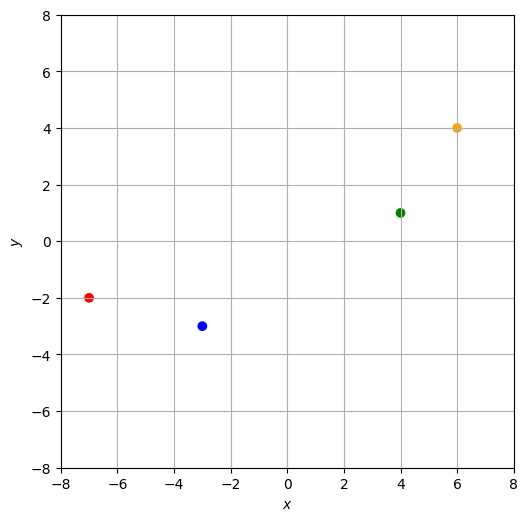

In [3]:
D = np.array([[-7, -2], [-3, -3], [4, 1], [6, 4]])
C = ['red', 'blue', 'green', 'orange']

fig = plt.figure(dpi=100, figsize=(6, 6))
ax = fig.add_subplot(1,1,1)
ax.scatter(D[:,0], D[:,1], marker='o', color=C)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()

このデータ$\mathcal{D}_s$を次のように表すことにする（$i \in \{1, 2, 3, 4\}$は事例に対するインデックスである）。
\begin{align}
\mathcal{D}_s = \{(x_i, y_i)\}_{i=1}^{4} = \{(-7,-2),(-3,-3),(4,1),(6,4)\}
\end{align}

なお、
\begin{align}
\frac{1}{4}\left(-7 -3 + 4 + 6\right) = 0,\; \frac{1}{4}\left(-2 -3 + 1 + 4\right) = 0 \\
\end{align}
であるから、この４点の重心は原点$(0,0)$である（データの重心が原点にない場合の取り扱いは次章で説明する）。

## データ点を直線へ射影

さて、各点$(x_i, y_i) \in \mathbb{R}^2$を$xy$平面上で原点を通る直線に射影し、その直線上の点$(\hat{x}_i, \hat{y}_i)$で近似的に表現したい。原点を通る直線は、長さ$1$の方向ベクトル$\pmb{u} \in \mathbb{R}^2$と媒介変数$a \in \mathbb{R}$を用いて、$a \pmb{u}$で表される。したがって、点$(x_i, y_i)$を射影した点$(\hat{x}_i, \hat{y}_i)$は、$a_i \in \mathbb{R}$を用いて次式で表される。

\begin{align}
\begin{pmatrix}\hat{x}_i \\ \hat{y}_i\end{pmatrix} = a_i \pmb{u}
\end{align}

なお、$|a_i|$は射影された点$(\hat{x}_i, \hat{y}_i)$の原点からの距離を表す。射影された点が方向ベクトルと同じ向きにあるときは$a_i$は正の値、反対の向きにあるときは$a_i$は負の値をとることとし、$a_i$を直線上の位置と呼ぶ。以上の定式化により、元のデータ点$(x_i, y_i)$は$\pmb{u}$が定める（１次元の）数直線上の位置$a_i$として近似的に表現される。

例えば、直線$y=\frac{1}{2}x$を考えると、元のデータ点（丸印）は射影された点（データ点から降ろした垂線の足、四角印）で近似的に表現される。

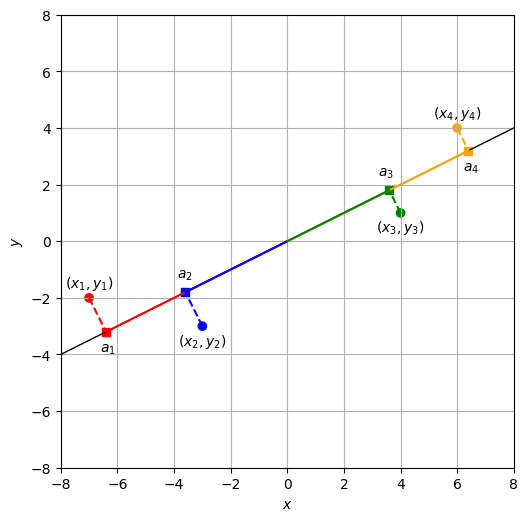

In [4]:
def draw_projections(ax, q, fill=False, show_a = False, show_e = False, show_xy=False):
    artist = []
    ya = ['bottom', 'top', 'top', 'bottom']
    yoffs = np.array([0.2, -0.2, -0.2, 0.2])
    axoffs = np.array([-0.2, -0.3, -0.4, -0.2])
    ayoffs = np.array([-0.7, 0.5, 0.5, -0.7])
    exoffs = np.array([-0.8, -0.3, 0.3, -0.1])
    eyoffs = np.array([0.35, -0.8, -0.4, 0.35])
    
    P = []
    for i in range(D.shape[0]):
        x, y = D[i,0], D[i,1]
        # Project (x, y) onto the line q.
        d = np.dot(np.array([x, y]), q)
        p = d * q
        artist.append(ax.scatter(p[0], p[1], marker='s', color=C[i]))
        if show_a:
            artist.append(ax.text(p[0] + axoffs[i], p[1] + ayoffs[i], '$a_{}$'.format(i+1)))
        if show_e:
            artist.append(ax.text(p[0] + exoffs[i], p[1] + eyoffs[i], '$\epsilon_{}$'.format(i+1)))            
        if show_xy:
            artist.append(ax.text(x, y + yoffs[i], '$(x_{0}, y_{0})$'.format(i+1), ha='center', va=ya[i]))
        artist += ax.plot([x, p[0]], [y, p[1]], ls='--', color=C[i])
        P.append((i, p)) 

    # Sort the projected points so that we can draw lines in an appropriate order.
    P.sort(key=lambda x: np.dot(x[1], x[1]), reverse=True)
    for i, p in P:
        artist += ax.plot([0, p[0]], [0, p[1]], ls='-', color=C[i])
        if fill:
            tri = plt.Polygon(((0, 0), D[i], p), fc=C[i], alpha=0.2)
            artist.append(ax.add_patch(tri))

    return artist

u = np.array([2, 1])
uy = 8 * u[1] / u[0]

fig = plt.figure(dpi=100, figsize=(6, 6))
ax = fig.add_subplot(1,1,1)
ax.scatter(D[:,0], D[:,1], marker='o', color=C)
ax.plot([-8, 8], [-uy, uy], ls='-', color='black', lw=1)
draw_projections(ax, u / np.linalg.norm(u), show_a=True, show_xy=True)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()

$a_i$を求めるため、直線$y=\frac{1}{2}x$に対応する長さ$1$の方向ベクトル$\pmb{u}$を求める。

\begin{align}
\pmb{u} = \frac{1}{\sqrt{2^2 + 1^2}}\begin{pmatrix}2 \\ 1\end{pmatrix} = \begin{pmatrix}\frac{2}{\sqrt{5}} \\ \frac{1}{\sqrt{5}}\end{pmatrix}
\end{align}

ある点$(x_i, y_i)$を方向ベクトル$\pmb{u}$上に射影したとき、その位置$a_i$は、

$$
\begin{align}
a_i = \left|\begin{pmatrix}x_i \\ y_i\end{pmatrix}\right| \cos \theta = \left|\begin{pmatrix}x_i \\ y_i\end{pmatrix}\right| \frac{\begin{pmatrix}x_i \\ y_i\end{pmatrix}^\top \pmb{u}}{\left|\begin{pmatrix}x_i \\ y_i\end{pmatrix}\right| |\pmb{u}|} = \begin{pmatrix}x_i \\ y_i\end{pmatrix}^\top \pmb{u}
\end{align}
$$ (eq:definition-of-a)

と求めることができる。ここで、$\theta$は位置ベクトル$(x_i, y_i)$と方向ベクトル$\pmb{u}$のなす角である。ゆえに、

\begin{align}
a_1 &= \begin{pmatrix}-7 & -2\end{pmatrix} \begin{pmatrix}\frac{2}{\sqrt{5}} \\ \frac{1}{\sqrt{5}}\end{pmatrix} \approx -7.16 \\
a_2 &= \begin{pmatrix}-3 & -3\end{pmatrix} \begin{pmatrix}\frac{2}{\sqrt{5}} \\ \frac{1}{\sqrt{5}}\end{pmatrix} \approx -4.02 \\
a_3 &= \begin{pmatrix}4 & 1\end{pmatrix} \begin{pmatrix}\frac{2}{\sqrt{5}} \\ \frac{1}{\sqrt{5}}\end{pmatrix} \approx 4.02 \\
a_4 &= \begin{pmatrix}6 & 4\end{pmatrix} \begin{pmatrix}\frac{2}{\sqrt{5}} \\ \frac{1}{\sqrt{5}}\end{pmatrix} \approx 7.16 \\
\end{align}

以上により、データ$\mathcal{D}_s$の各事例$(x_i, y_i)$を方向ベクトル$\pmb{u}$と、位置$a_i$で近似的に表現したことになる。各事例$(x_i, y_i)$を射影した点$(\hat{x}_i, \hat{y}_i)$は、

\begin{align}
\begin{pmatrix}\hat{x}_1 \\ \hat{y}_1\end{pmatrix} &= -7.16 \begin{pmatrix}\frac{2}{\sqrt{5}} \\ \frac{1}{\sqrt{5}}\end{pmatrix} = \begin{pmatrix}-6.4 \\ -3.2 \end{pmatrix}\\
\begin{pmatrix}\hat{x}_2 \\ \hat{y}_2\end{pmatrix} &= -4.02 \begin{pmatrix}\frac{2}{\sqrt{5}} \\ \frac{1}{\sqrt{5}}\end{pmatrix} = \begin{pmatrix}-3.6 \\ -1.8 \end{pmatrix}\\
\begin{pmatrix}\hat{x}_3 \\ \hat{y}_3\end{pmatrix} &= 4.02 \begin{pmatrix}\frac{2}{\sqrt{5}} \\ \frac{1}{\sqrt{5}}\end{pmatrix} = \begin{pmatrix}3.6 \\ 1.8 \end{pmatrix} \\
\begin{pmatrix}\hat{x}_4 \\ \hat{y}_4\end{pmatrix} &= 7.16 \begin{pmatrix}\frac{2}{\sqrt{5}} \\ \frac{1}{\sqrt{5}}\end{pmatrix} = \begin{pmatrix}6.4 \\ 3.2 \end{pmatrix} \\
\end{align}

## 近似の良さの定量化

直線への射影による近似の良さを定量化するため、元データの各点$(x_i, y_i)$から直線上に垂線を降ろしたときの長さを$\epsilon_i$とし、これを残差と呼ぶ。三平方の定理（ピタゴラスの定理）より、

\begin{align}
x_i^2 + y_i^2 = a_i^2 + \epsilon_i^2
\end{align}

が成り立つ。以下のグラフでは、各事例に関して直角三角形を色付けして描いている。直線$y=\frac{1}{2}x$上の面を底辺、垂線を高さとすると、

+ $x_i^2 + y_i^2$: 斜面の長さの二乗（原点から丸印までの距離の二乗）
+ $a_i^2$: 底辺の長さの二乗（原点から四角印までの距離の二乗）
+ $\epsilon_i^2$: 高さ（点線）の二乗（残差の二乗）

と整理できる。

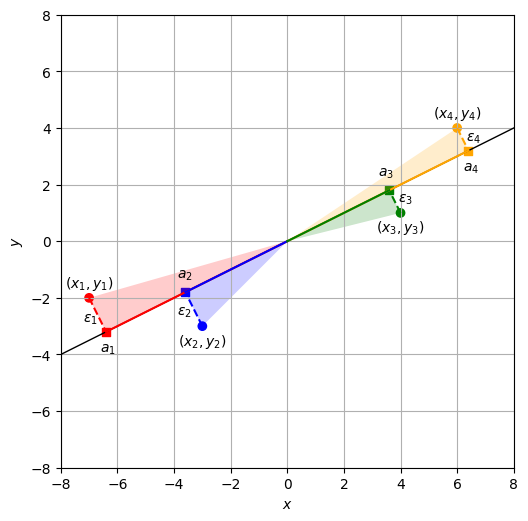

In [5]:
u = np.array([2, 1])
uy = 8 * u[1] / u[0]

fig = plt.figure(dpi=100, figsize=(6, 6))
ax = fig.add_subplot(1,1,1)
ax.scatter(D[:,0], D[:,1], marker='o', color=C)
ax.plot([-8, 8], [-uy, uy], ls='-', color='black', lw=1)
draw_projections(ax, u / np.linalg.norm(u), True, show_a=True, show_e=True, show_xy=True)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()

これまでの議論では、データ点を射影する直線（方向ベクトル$\pmb{u}$）を固定していたが、以降は射影された点の良さを考慮しながら様々な直線を検討したい。今回のデータ$\mathcal{D}_s$の重心は原点であるため、直線の切片は$0$に固定し、直線の傾きだけを変更する。回帰分析と同様に、方向ベクトル$\pmb{u}$で元のデータ点を射影したときの「良さ」を、全てのデータ点の残差の二乗和で定量化する。

\begin{align}
\sum_{i=1}^{N} \epsilon_i^2
\end{align}

なお、2次元のデータにおいて、線形回帰では$y$軸に関する実際の値と近似値の値の差$\epsilon = y - \hat{y}$を残差として定義したのに対し、主成分分析では事例を直線に射影したときの垂線の長さ$\epsilon = \sqrt{(x - \hat{x})^2 + (y - \hat{y})^2}$を残差として定義する所が異なる。

さて、直線の傾きを変えながら射影された点をプロットするアニメーションを示す。

In [6]:
K = 50
X = np.hstack([np.linspace(-8, 8, K, endpoint=False), np.full(K-1, 8)])
Y = np.hstack([np.full(K-1, -8), np.linspace(-8, 8, K, endpoint=False)])

fig = plt.figure(dpi=100, figsize=(6, 6))
ax = fig.add_subplot(1,1,1)
ax.scatter(D[:,0], D[:,1], marker='o', color=C)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()

artists = []
for x, y in zip(X, Y):
    q = np.array([-x, -y]) - np.array([x, y])
    artist = []
    artist += ax.plot([x, -x], [y, -y], ls='-', color='black', lw=1)
    artist += draw_projections(ax, q / np.linalg.norm(q), True)
    artists.append(artist)

ani = matplotlib.animation.ArtistAnimation(fig, artists, interval=100)
#ani.save('pca.mp4', writer="ffmpeg")
html = ani.to_jshtml()
plt.close(fig)
HTML(html)

このアニメーションを注意深く観察すると、残差の二乗和が小さくなる、すなわち各三角形の高さ$\epsilon_i$が短くなるとき、各三角形の底辺の長さ$a_i$が大きくなり、三角形が直線方向に大きく広がることが分かる。各点について三平方の定理を適用すると、

\begin{align}
a_1^2 + \epsilon_1^2 &= x_1^2 + y_1^2 \\
a_2^2 + \epsilon_2^2 &= x_2^2 + y_2^2 \\
a_3^2 + \epsilon_3^2 &= x_3^2 + y_3^2 \\
a_4^2 + \epsilon_4^2 &= x_4^2 + y_4^2 \\
\end{align}

この４つの式の両辺を足すと、

\begin{align}
a_1^2 + \epsilon_1^2 + a_2^2 + \epsilon_2^2 + a_3^2 + \epsilon_3^2 + a_4^2 + \epsilon_4^2 &= x_1^2 + y_1^2 + x_2^2 + y_2^2 + x_3^2 + y_3^2 + x_4^2 + y_4^2 \\
\left(a_1^2 + a_2^2 + a_3^2 + a_4^2\right) + \left(\epsilon_1^2 + \epsilon_2^2 + \epsilon_3^2 + \epsilon_4^2\right) &= x_1^2 + y_1^2 + x_2^2 + y_2^2 + x_3^2 + y_3^2 + x_4^2 + y_4^2
\end{align}

左辺の$\left(a_1^2 + a_2^2 + a_3^2 + a_4^2\right)$は「直線に射影した各点の原点からの距離の二乗和」、$\left(\epsilon_1^2 + \epsilon_2^2 + \epsilon_3^2 + \epsilon_4^2\right)$は「直線に射影した各点の残差の二乗和」である。右辺はデータが与えられると直線の傾きに依らず計算できる定数であり、今回のデータ$\mathcal{D}_s$では$140$である。

一般に、以下の関係が成り立つ。

\begin{align}
\sum_{i=1}^N a_i^2 + \sum_{i=1}^N \epsilon_i^2 &= \sum_{i=1}^N \left(x_i^2 + y_i^2\right)
\end{align}

ゆえに、残差の二乗和を最小にする方向ベクトル$\pmb{u}^*$を求めることは、$a_i$の二乗和を最大にする単位ベクトル$\pmb{u}^*$を求めることと等価である。

\begin{align}
\pmb{u}^* &= \mathop{\rm argmin}\limits_{\|\pmb{u}\|=1} \sum_{i=1}^N \epsilon_i^2 \\
&= \mathop{\rm argmin}\limits_{\|\pmb{u}\|=1} \left\{ \sum_{i=1}^N \left(x_i^2 + y_i^2\right) - \sum_{i=1}^N a_i^2 \right\} \\
&= \mathop{\rm argmin}\limits_{\|\pmb{u}\|=1} \left\{ (\mbox{$\pmb{u}$によらない定数}) - \sum_{i=1}^N a_i^2 \right\} \\
&= \mathop{\rm argmax}\limits_{\|\pmb{u}\|=1} \sum_{i=1}^N a_i^2
\end{align}

ところで、元のデータの重心が原点にあるとき、$a_i$の和も$0$になる。

\begin{align}
\sum_{i=1}^N a_i = \sum_{i=1}^N \begin{pmatrix}x_i \\ y_i\end{pmatrix}^\top \pmb{u}
= \begin{pmatrix}\sum_{i=1}^N x_i \\ \sum_{i=1}^N y_i\end{pmatrix}^\top \pmb{u}
= \begin{pmatrix}0 \\ 0\end{pmatrix}^\top \pmb{u}
= 0
\end{align}

これは、$a_i$の平均$\bar{a}$が$0$であることを意味する。すると、

\begin{align}
\mathrm{Var}[\pmb{a}] = \frac{1}{N}\sum_{i=1}^N (a_i - \bar{a})^2 = \frac{1}{N}\sum_{i=1}^N a_i^2
\end{align}

であるから、

\begin{align}
\pmb{u}^* = \mathop{\rm argmax}\limits_{\|\pmb{u}\|=1} \sum_{i=1}^N a_i^2 = \mathop{\rm argmax}\limits_{\|\pmb{u}\|=1} N \cdot \mathrm{Var}[\pmb{a}] = \mathop{\rm argmax}\limits_{\|\pmb{u}\|=1} \mathrm{Var}[\pmb{a}]
\end{align}

したがって、データ点を直線に射影し、近似的に表現するとき、その**残差の二乗和を最小化する**ようにベクトル$\pmb{u}$を選ぶことと、**射影された点の分散を最大化する**ようにベクトル$\pmb{u}$を選ぶことは**等価**である。後者は射影された点の分散を大きくとることで、元のデータ点の情報をできるだけ保存しようとしていると解釈できる。主成分分析は「元データを写像したときの分散が大きくなるような軸を見つける」と説明されることがあるが、これは「元データの情報をできるだけ豊富に表現できるような軸を見つける」や「元データを射影したときの残差ができるだけ小さくなるような軸を見つける」という動機に基づいている。

## 第１主成分を求める

これまでの議論により、データ$\mathcal{D}_s$を「よく」射影するベクトル$\pmb{u}$を求めることは、$\|\pmb{u}\|=1$の制約下で、以下の目的関数$J$を最大化する問題に帰着した。

\begin{align}
J = \sum_{i=1}^4 a_i^2
\end{align}

ここで、$\pmb{a} = \begin{pmatrix}a_1 & a_2 & a_3 & a_4\end{pmatrix}^\top$と表すことにすると、

\begin{align}
J = \sum_{i=1}^4 a_i^2
  = \begin{pmatrix}a_1 & a_2 & a_3 & a_4\end{pmatrix} \begin{pmatrix}a_1 \\ a_2 \\ a_3 \\ a_4\end{pmatrix}
  = \pmb{a}^\top \pmb{a}
\end{align}

そこで、式{eq}`eq:definition-of-a`の$\pmb{a}$の定義に立ち返って整理してみる。

$$
\begin{align}
\pmb{a} = \begin{pmatrix}a_1 \\ a_2 \\ a_3 \\ a_4\end{pmatrix}
= \begin{pmatrix}\begin{pmatrix}x_1 & y_1\end{pmatrix} \pmb{u} \\ \begin{pmatrix}x_2 & y_2\end{pmatrix} \pmb{u} \\ \begin{pmatrix}x_3 & y_3\end{pmatrix} \pmb{u} \\ \begin{pmatrix}x_4 & y_4\end{pmatrix} \pmb{u}\end{pmatrix}
= \begin{pmatrix}x_1 & y_1 \\ x_2 & y_2 \\ x_3 & y_3 \\ x_4 & y_4\end{pmatrix} \pmb{u}
= \pmb{X} \pmb{u}
\end{align}
$$ (eq:definition-of-vector-a)

なお、行列$\pmb{X} = \mathbb{R}^{4 \times 2}$はデータ点（事例）のベクトルを並べたものである。

\begin{align}
\pmb{X} = \begin{pmatrix}x_1 & y_1 \\ x_2 & y_2 \\ x_3 & y_3 \\ x_4 & y_4\end{pmatrix}
\end{align}

すると、目的関数$J$は、

\begin{align}
J = \pmb{a}^\top \pmb{a}
= \left(\pmb{X} \pmb{u}\right)^\top \left(\pmb{X} \pmb{u}\right)
= \left(\pmb{u}^\top \pmb{X}^\top\right)\left(\pmb{X} \pmb{u}\right)
= \pmb{u}^\top \left(\pmb{X}^\top \pmb{X}\right) \pmb{u}
= \pmb{u}^\top \pmb{S} \pmb{u}
\end{align}

と整理できる。$\pmb{S} = \pmb{X}^\top \pmb{X}$は対称行列である。

\begin{align}
\pmb{S} = \pmb{X}^\top \pmb{X} &= \begin{pmatrix}x_1 & x_2 & x_3 & x_4 \\ y_1 & y_2 & y_3 & y_4\end{pmatrix} \begin{pmatrix}x_1 & y_1 \\ x_2 & y_2 \\ x_3 & y_3 \\ x_4 & y_4\end{pmatrix} \\
&= \begin{pmatrix}x_1^2 + x_2^2 + x_3^2 + x_4^2 & x_1 y_1 + x_2 y_2 + x_3 y_3 + x_4 y_4 \\ x_1 y_1 + x_2 y_2 + x_3 y_3 + x_4 y_4 & y_1^2 + y_2^2 + y_3^2 + y_4^2\end{pmatrix} 
\end{align}


$\pmb{u}$を求めることは、制約$\|\pmb{u}\|=1$のもとで目的関数$J$を最大化する問題であるので、ラグランジュの未定乗数法で制約なしの問題に書き換える。すると、$\lambda$をラグランジュ乗数として、以下のラグランジュ関数$\mathcal{L}(\pmb{u}, \lambda)$を最大化する問題に帰着する。

\begin{align}
\mathcal{L}(\pmb{u}, \lambda) &= \pmb{u}^\top \pmb{S} \pmb{u} - \lambda (\pmb{u}^\top\pmb{u} - 1)
\end{align}

ラグランジュ関数$\mathcal{L}(\pmb{u}, \lambda)$を$\pmb{u}$で偏微分すると、
\begin{align}
\frac{\partial \mathcal{L}(\pmb{u}, \lambda)}{\partial \pmb{u}} &= \frac{\partial}{\partial \pmb{u}} \left(\pmb{u}^\top \pmb{S} \pmb{u}\right) - \frac{\partial}{\partial \pmb{u}} \lambda (\pmb{u}^\top\pmb{u} - 1) \\
&= (\pmb{S} + \pmb{S}^\top)\pmb{u} - 2\pmb{u} \\
&= 2(\pmb{S} \pmb{u} - \lambda \pmb{u}) \\
\end{align}

これを$0$とおくと、

\begin{align}
\frac{\partial \mathcal{L}(\pmb{u}, \lambda)}{\partial \pmb{u}} = 2(\pmb{S} \pmb{u} - \lambda\pmb{u}) &= 0 \\
\pmb{S} \pmb{u} &= \lambda\pmb{u} \\
(\pmb{S} - \lambda \pmb{I}) \pmb{u} &= 0
\end{align}

ゆえに、$\pmb{S} = \pmb{X}^\top \pmb{X}$の固有値問題に帰着した。$\lambda$が$\pmb{S}$の固有値であるので、特性方程式は、

\begin{align}
\mathrm{det}|\pmb{S} - \lambda \pmb{I}| &= 0 \\
\mathrm{det}\begin{vmatrix}S_{1,1} - \lambda & S_{1,2} \\ S_{2,1} & S_{2,2} - \lambda \end{vmatrix} &= 0 \\
(S_{1,1} - \lambda) (S_{2,2} - \lambda) - S_{1,2} S_{2,1} &= 0
\end{align}

さて、データ$\mathcal{D}_s$の例で実際に計算を進める。

\begin{align}
\pmb{S} &= \pmb{X}^\top \pmb{X} = \begin{pmatrix}-7 & -3 & 4 & 6 \\-2 & -3 & 1 & 4\end{pmatrix}\begin{pmatrix}-7 & -2 \\ -3 & -3 \\ 4 & 1 \\ 6 & 4\end{pmatrix} = \begin{pmatrix}110 & 51 \\ 51 & 30\end{pmatrix}
\end{align}

であるから、特性方程式は、

\begin{align}
(110 - \lambda)(30 - \lambda) - 51^2 &= 0 \\
\lambda^2 - 140x + 699 &=0 \\
\lambda &= 70 \pm \sqrt{4201} \\
\lambda &\approx 134.8, 5.185 
\end{align}

$J$を最大化する解として、$\lambda \approx 134.8$と$\lambda \approx 5.185$のどちらを選べばよいのか？　$\pmb{S} \pmb{u} = \lambda\pmb{u}$の両辺に左から$\pmb{u}^\top$をかけると、左辺は目的関数$J$に一致する。右辺は$\|\pmb{u}\|=1$であることに注意すると、

\begin{align}
\pmb{u}^\top\pmb{S} \pmb{u} &= \pmb{u}^\top \lambda \pmb{u} \\
J &= \lambda \pmb{u}^\top \pmb{u} = \lambda
\end{align}

したがって、求めた固有値$\lambda$が目的関数の値となる。そこで、固有値のうち大きい方を$\lambda_1$と書くことにして、$\lambda_1 = 134.8$とする。$\pmb{S}$の固有値問題の等式に$\lambda = 134.8$を代入すると、

\begin{align}
(\pmb{S} - 134.8 \pmb{I}) \pmb{u} &= 0 \\
\begin{pmatrix}-24.8 & 51 \\ 51 & -104.8\end{pmatrix} \pmb{u} &= 0 \\
\end{align}

であるから、

\begin{align}
\begin{cases}
-24.8 u_1 + 51 u_2 &= 0 \\
51 u_1 - 104.8 u_2 &= 0
\end{cases}
\Longleftrightarrow
\begin{cases}
0.486 u_1 - u_2 &= 0 \\
0.486 u_1 - u_2 &= 0
\end{cases}
\end{align}

したがって、$c$をスカラー値の定数として、

\begin{align}
\pmb{u} = c\begin{pmatrix}1 \\ 0.486\end{pmatrix}
\end{align}

と表される。さらに制約$\|\pmb{u}\|=1$を満たすように$\pmb{u}$を求めると、

\begin{align}
\pmb{u} = \begin{pmatrix}0.899 \\ 0.437\end{pmatrix}
\end{align}

このように求めた$\pmb{u}$を**第１主成分**（the first principal component）と呼ぶ。$\lambda_1$は目的関数の値そのものであるから、データを第１主成分の軸に写像したときの分散は$\lambda_1 = 134.8$である。各データ点$(x_i, y_i)$を第１主成分の直線上に写像したときの位置$a_i$を**第１主成分得点**（the first principal component score）と呼ぶ。式{eq}`eq:definition-of-vector-a`を用いて実際に主成分得点を求めてみると、

\begin{align}
\pmb{a} = \pmb{X}\pmb{u} = \begin{pmatrix}-7 & -2 \\ -3 & -3 \\ 4 & 1 \\ 6 & 4\end{pmatrix} \begin{pmatrix}0.899 \\ 0.437\end{pmatrix} \approx \begin{pmatrix}-7.17 \\ -4.01 \\ 4.03 \\ 7.15\end{pmatrix}
\end{align}

実際に求めた$\pmb{u}$を可視化した（おおよそ、これまで例に用いていた$y=\frac{1}{2}x$に近いが、それよりも少しずれた直線が解であった）。

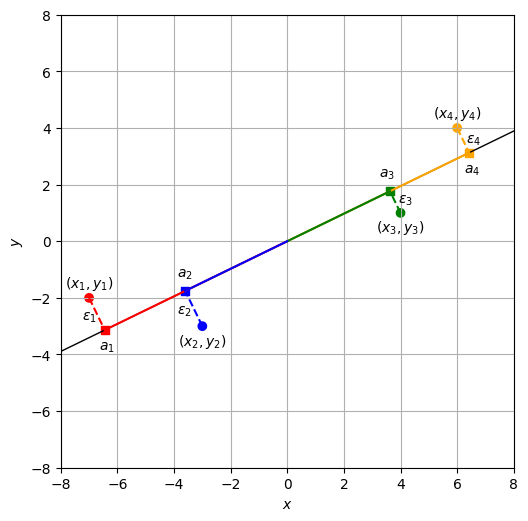

In [7]:
u = np.array([0.89920519, 0.43752718])
uy = 8 * u[1] / u[0]

fig = plt.figure(dpi=100, figsize=(6, 6))
ax = fig.add_subplot(1,1,1)
ax.scatter(D[:,0], D[:,1], marker='o', color=C)
ax.plot([-8, 8], [-uy, uy], ls='-', color='black', lw=1)
draw_projections(ax, u / np.linalg.norm(u), show_a=True, show_e=True, show_xy=True)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.grid()

## 第２主成分を求める

先ほど求めた第１主成分の軸は元データを近似的によく表現しているが、残差$\epsilon_i$が残っている。残差は各データ点から第１主成分の直線に降ろした垂線の長さであるから、この残差を表現するには第１主成分のベクトルと直交するベクトルを求めればよい。すなわち、残差を表現する直線の方向ベクトルを$\pmb{v}$とおき、$\|\pmb{v}\|=1$かつ$\pmb{u}^\top\pmb{v}=0$を満たすベクトル$\pmb{v}$を求めればよい。$u_1 v_1 + u_2 v_2 = 0$であるから、

$$
\begin{align}
\pmb{v} = \begin{pmatrix}-0.437 \\ 0.899\end{pmatrix}
\end{align}
$$ (eq:second-pc)

と求めることができる。この$\pmb{v}$が**第２主成分**（the second principal component）である。例として用いている$\mathcal{D}_s$は2次元のデータであるので、第３成分以降の軸を求める必要はない。

ただ、この求め方では2次元以上のデータに対応できないので、目的関数$J$を最大化しても$\pmb{v}$が求まることを説明する。データ$\mathcal{D}_s$を２番目に「よく」射影するベクトル$\pmb{v}$を求めることは、$\|\pmb{v}\|=1$および$\pmb{u}^\top \pmb{v}=0$の制約下で、以下の目的関数$J$を最大化すればよい。

\begin{align}
J = \pmb{v}^\top \pmb{S} \pmb{v}
\end{align}

これは、以下のラグランジュ関数$\mathcal{L}(\pmb{v}, \lambda, \alpha)$を最大化する問題に帰着する。

\begin{align}
\mathcal{L}(\pmb{u}, \lambda) &= \pmb{v}^\top \pmb{S} \pmb{v} - \lambda (\pmb{v}^\top\pmb{v} - 1) - \alpha \pmb{u}^\top \pmb{v}
\end{align}

ただし、$\lambda$と$\alpha$はラグランジュ乗数である。ラグランジュ関数$\mathcal{L}(\pmb{v}, \lambda, \alpha)$を$\pmb{v}$で偏微分すると、

\begin{align}
\frac{\partial \mathcal{L}(\pmb{v}, \lambda, \alpha)}{\partial \pmb{v}} &= \frac{\partial}{\partial \pmb{v}} \left(\pmb{v}^\top \pmb{S} \pmb{v}\right) - \frac{\partial}{\partial \pmb{v}}  \left(\lambda (\pmb{v}^\top\pmb{v} - 1)\right)  - \frac{\partial}{\partial \pmb{v}} \left(\alpha \pmb{u}^\top \pmb{v}\right) \\
&= (\pmb{S} + \pmb{S}^\top)\pmb{v} - 2\pmb{v} - \alpha \pmb{u} \\
&= 2\pmb{S} \pmb{v} - 2\lambda\pmb{v}  - \alpha \pmb{u} \\
\end{align}

これを$0$とおくと、

\begin{align}
2\pmb{S} \pmb{v} - 2\lambda\pmb{v}  - \alpha \pmb{u} &= 0
\end{align}

ここで、左から$\pmb{u}^\top$をかけ、$\pmb{u}^\top\pmb{v}=0$と$\pmb{u}^\top\pmb{u}=1$であることに注意すると、

\begin{align}
2\pmb{u}^\top \pmb{S} \pmb{v} - 2\lambda\pmb{u}^\top\pmb{v}  - \alpha \pmb{u}^\top\pmb{u} &= 0 \\
2\pmb{u}^\top\pmb{S} \pmb{v} - \alpha &= 0 \\
\alpha &= 2\pmb{u}^\top\pmb{S} \pmb{v} = 2\pmb{v}^\top\pmb{S} \pmb{u} \\
\end{align}

なお、最終行の式変形では、$\pmb{u}^\top\pmb{S} \pmb{v}$がスカラーであるから、$(\pmb{u}^\top\pmb{S} \pmb{v})^\top = \pmb{v}^\top\pmb{S} \pmb{u}$が成り立つことを用いた。ここで、第１主成分を求めたときの固有値問題により、$\pmb{S} \pmb{u} = \lambda_1 \pmb{u}$であるから、

\begin{align}
\alpha &= 2\pmb{v}^\top (\pmb{S} \pmb{u}) = 2\pmb{v}^\top (\lambda_1 \pmb{u}) = 2 \lambda_1 \pmb{v}^\top \pmb{u} = 0
\end{align}

したがって、$\alpha = 0$であるから、ラグランジュ関数$\mathcal{L}(\pmb{v}, \lambda, \alpha)$を$\pmb{v}$で偏微分して$0$とおいた式は、

\begin{align}
2\pmb{S} \pmb{v} - 2\lambda\pmb{v}  &= 0 \\
\pmb{S} \pmb{v} &= \lambda\pmb{v}
\end{align}

となり、再び$\pmb{S}$の固有値問題に帰着した。そこで、先ほど求めた固有値のうち小さい方を$\lambda_2$と書くことにして、$\lambda_2 = 5.185$とする。$\pmb{S}$の固有値問題の等式に$\lambda = 5.185$を代入すると、

\begin{align}
(\pmb{S} - 5.185 \pmb{I}) \pmb{v} &= 0 \\
\begin{pmatrix}104.8 & 51 \\ 51 & 24.82\end{pmatrix} \pmb{v} &= 0 \\
\end{align}

であるから、

\begin{align}
\begin{cases}
104.8 v_1 + 51 v_2 &= 0 \\
51 v_1 + 24.82 v_2 &= 0
\end{cases}
\Longleftrightarrow
\begin{cases}
2.055 v_1 + v_2 &= 0 \\
2.055 v_1 + v_2 &= 0
\end{cases}
\end{align}

したがって、$c$をスカラー値の定数として、

\begin{align}
\pmb{v} = c\begin{pmatrix}1 \\ -2.055\end{pmatrix}
\end{align}

と表される。さらに制約$\|\pmb{v}\|=1$を満たすように$\pmb{v}$を求めると、

\begin{align}
\pmb{v} = \begin{pmatrix}0.438 \\ -0.899\end{pmatrix} 
\end{align}

このように求めた$\pmb{v}$を第２主成分と呼ぶ。式{eq}`eq:second-pc`で求めた$\pmb{v}$と逆向きであるが、固有値問題の解から同じ第２主成分が求まった。$\lambda_2$も目的関数の値そのものであるから、データを第２主成分の軸に写像したときの分散は$\lambda_2 = 5.185$である。式{eq}`eq:definition-of-vector-a`を用いて第２主成分得点を求めてみると、

\begin{align}
\pmb{a} = \pmb{X}\pmb{u} = \begin{pmatrix}-7 & -2 \\ -3 & -3 \\ 4 & 1 \\ 6 & 4\end{pmatrix} \begin{pmatrix}0.438 \\ -0.899\end{pmatrix} \approx \begin{pmatrix}1.26 \\ -1.39 \\ -0.85 \\ 0.97\end{pmatrix}
\end{align}

このデータに対する主成分分析の締めくくりとして、データ$\mathcal{D}_s$の第１主成分$\pmb{u}$と第２主成分$\pmb{v}$を可視化した。

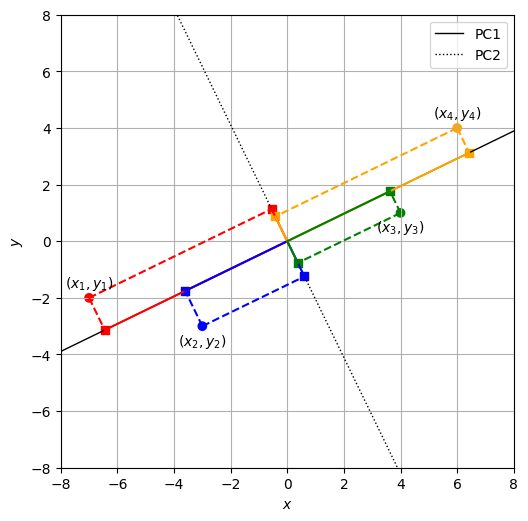

In [8]:
u = np.array([0.89920519, 0.43752718])
uy = 8 * u[1] / u[0]

v = np.array([-0.43752718, 0.89920519])
vy = 8 * v[1] / v[0]

fig = plt.figure(dpi=100, figsize=(6, 6))
ax = fig.add_subplot(1,1,1)
ax.scatter(D[:,0], D[:,1], marker='o', color=C)
ax.plot([-8, 8], [-uy, uy], ls='-', color='black', lw=1, label='PC1')
ax.plot([-8, 8], [-vy, vy], ls=':', color='black', lw=1, label='PC2')
draw_projections(ax, u / np.linalg.norm(u), show_xy=True)
draw_projections(ax, v / np.linalg.norm(v))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.legend()
ax.grid()

## 実装

例として用いてきたデータ$\pmb{X}$に対して、主成分分析を行う。

\begin{align*}
\pmb{X} = \begin{pmatrix}-7 & -2 \\ -3 & -3 \\ 4 & 1 \\ 6 & 4\end{pmatrix}
\end{align*}

In [9]:
X = np.array([[-7, -2], [-3, -3], [4, 1], [6, 4]])

[sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)で$X$の主成分分析を行う。

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

第１主成分と第２主成分。先ほど求めた主成分と符号が異なっているが、実質的に同じものである。

In [11]:
pca.components_

array([[-0.89920519, -0.43752718],
       [ 0.43752718, -0.89920519]])

第１主成分と第２主成分に対応する固有値。

In [12]:
pca.singular_values_ ** 2

array([134.81512169,   5.18487831])

主成分得点を求める。

In [13]:
pca.transform(X)

array([[ 7.16949066, -1.26427988],
       [ 4.0101971 ,  1.38503402],
       [-4.03434793,  0.85090353],
       [-7.14533984, -0.97165767]])

## 確認問題

先ほどの実装では、[sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)を用いて主成分分析を行ったが、行列$\pmb{S} = \pmb{X}^\top \pmb{X}$に対して固有値問題を解くことで、主成分分析が得られることを確認したい。

**(1) $\pmb{S}$の計算**

$\pmb{X}$に対して、行列$\pmb{S} = \pmb{X}^\top \pmb{X}$を求めよ。

\begin{align*}
\pmb{X} = \begin{pmatrix}-7 & -2 \\ -3 & -3 \\ 4 & 1 \\ 6 & 4\end{pmatrix}
\end{align*}

**(2) 固有値問題の解**

[numpy.linalg.eig](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html)等で$\pmb{S}$の固有値問題を解き、固有値と固有ベクトルを求めよ。

**(3) 第１主成分と第２主成分**

第１主成分と第１主成分軸における分散、第２主成分と第２主成分軸における分散を求めよ。

**(4) 第１主成分得点と第２主成分得点**

第１主成分得点と第２主成分得点を求めよ。

---

[機械学習帳](https://chokkan.github.io/mlnote/) © Copyright 2020-2021 by [岡崎 直観 (Naoaki Okazaki)](https://www.chokkan.org/). この作品は<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">クリエイティブ・コモンズ 表示 - 非営利 - 改変禁止 4.0 国際 ライセンス</a>の下に提供されています。 <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="クリエイティブ・コモンズ・ライセンス" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/80x15.png" /></a>　ただし、作品中のコードセル部分は<a rel="license" href="https://opensource.org/licenses/MIT">MITライセンス</a>の下に提供されています。